# ASSESSMENT: Evil Geniuses x Genius League: Data Scientist Internship

### Author: Uditi Namdev

## Importing Libraries

<font size='3'> This work is completed as a part of an assessment for Evil Geniuses x Genius League: Data Scientist Internship. The company provided us with csv file of player game data: starcraft_player_data.csv which consists of Starcraft player performance data in ranked games. The objective of this assessment is to predict a player’s rank using the information provided in the dataset. I started by importing all the libraries and packages needed for this task.</font>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Exploration and Cleaning

In [3]:
df = pd.read_csv('starcraft_player_data.csv', index_col="GameID")

In [4]:
df.head()

LeagueIndex Age HoursPerWeek TotalHours       APM  SelectByHotkeys  \
GameID                                                                       
52                5  27           10       3000  143.7180         0.003515   
55                5  23           10       5000  129.2322         0.003304   
56                4  30           10        200   69.9612         0.001101   
57                3  19           20        400  107.6016         0.001034   
58                3  32           10        500  122.8908         0.001136   

        AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
GameID                                                                       
52             0.000220              7        0.000110            0.000392   
55             0.000259              4        0.000294            0.000432   
56             0.000336              4        0.000294            0.000461   
57             0.000213              1        0.000053            0.000543   
58             0.000327              2        0.000000            0.001329   

        NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
GameID                                                              
52          0.004849         32.6677        40.8673        4.7508   
55          0.004307         32.9194        42.3454        4.8434   
56          0.002926         44.6475        75.3548        4.0430   
57          0.003783         29.2203        53.7352        4.9155   
58          0.002368         22.6885        62.0813        9.3740   

        TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
GameID                                                                     
52                    28     0.001397                6               0.0   
55                    22     0.001193                5               0.0   
56                    22     0.000745                6               0.0   
57                    19     0.000426                7               0.0   
58                    15     0.001174                4               0.0   

        ComplexAbilitiesUsed  
GameID                        
52                  0.000000  
55                  0.000208  
56                  0.000189  
57                  0.000384  
58                  0.000019

<font size='3'>I attempt to observe if the dataset is balanced or imbalanced and notice that the counts of 'LeagueIndex' values which are 7 and 8 differ by a huge margin from the rest of the classes.</font>

In [5]:
df['LeagueIndex'].value_counts()

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

In [6]:
classes = [1,2,3,4,5,6,7,8]
num_rows = [167,347,553,811,806,621,35,55]
 
fig = px.pie(values=num_rows, names=classes, 
             color_discrete_sequence=px.colors.sequential.RdBu, title='Distribution of data according to LeagueIndex')
 
fig.update_traces(textposition='outside', 
                  textinfo='percent+label+value',
                  marker=dict(line=dict(color='#FFFFFF', width=2)),
                  textfont_size=12)
 
fig.show()

<font size='3'>I also check if there are any null values in the dataset.</font>

In [7]:
df.isnull().sum().sort_values(ascending=False)

LeagueIndex             0
NumberOfPACs            0
ComplexUnitsMade        0
UniqueUnitsMade         0
WorkersMade             0
TotalMapExplored        0
ActionsInPAC            0
ActionLatency           0
GapBetweenPACs          0
MinimapRightClicks      0
Age                     0
MinimapAttacks          0
UniqueHotkeys           0
AssignToHotkeys         0
SelectByHotkeys         0
APM                     0
TotalHours              0
HoursPerWeek            0
ComplexAbilitiesUsed    0
dtype: int64

<font size='3'> I check for the datatypes of all columns and notice that Age, HoursPerWeek, TotalHours are Object datatype and hence can contain some undesirable value other than the required int/float values.</font>

In [8]:
df.dtypes

LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [9]:
df['Age'].value_counts()

20    357
21    344
18    325
22    314
19    313
23    259
16    256
17    248
24    225
25    168
26    136
27    111
28     73
?      55
29     52
30     32
31     29
32     21
35     17
33     15
34     15
36      8
38      5
37      5
40      4
41      3
39      3
43      1
44      1
Name: Age, dtype: int64

<font size='3'> There is an unknown character '?' in our dataset. This will hamper the analysis so it is important to take care of these values by either imputation by mean or median of that column or by dropping those rows which contain these values. Initially I thought that dropping these values is a good idea and hence I dropped all such rows that contained '?'. I proceeded with the analysis in this fashion. But post analysis I realized that this method of dropping the values deleted an entire class of 'LeagueIndex' = 8. Therefore, I concluded that simply dropping the values is a bad approach to tackle this problem. </font>

<font size='3'> To overcome this, I had to come up with a way to retain all classes and replace the '?' with a value that was representative of the class. So, I decided to replace all '?' with the mean value of the class 'LeagueIndex' = 7 of the respective columns. I chose 'LeagueIndex' = 7 because it is more similar to the class 'LeagueIndex' = 8 compared to the other classes.</font>

In [10]:
df[df.eq("?").any(axis=1)].head()

LeagueIndex Age HoursPerWeek TotalHours       APM  SelectByHotkeys  \
GameID                                                                       
1064              5  17           20          ?   94.4724         0.003846   
5255              5  18            ?          ?  122.2470         0.006357   
10001             8   ?            ?          ?  189.7404         0.004582   
10005             8   ?            ?          ?  287.8128         0.029040   
10006             8   ?            ?          ?  294.0996         0.029640   

        AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
GameID                                                                       
1064           0.000783              3        0.000010            0.000135   
5255           0.000433              3        0.000014            0.000257   
10001          0.000655              4        0.000073            0.000618   
10005          0.001041              9        0.000231            0.000656   
10006          0.001076              6        0.000302            0.002374   

        NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
GameID                                                              
1064        0.004474         50.5455        54.9287        3.0972   
5255        0.003043         30.8929        62.2933        5.3822   
10001       0.006291         23.5130        32.5665        4.4451   
10005       0.005399         31.6416        36.1143        4.5893   
10006       0.006294         16.6393        36.8192        4.1850   

        TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
GameID                                                                     
1064                  31     0.000763                7          0.000106   
5255                  23     0.001055                5          0.000000   
10001                 25     0.002218                6          0.000000   
10005                 34     0.001138                6          0.000058   
10006                 26     0.000987                6          0.000000   

        ComplexAbilitiesUsed  
GameID                        
1064                0.000116  
5255                0.000338  
10001               0.000000  
10005               0.000000  
10006               0.000000

In [11]:
df_rep = df.copy()

In [12]:
df_rep.replace('?', 0, inplace=True)

In [13]:
df_rep[df_rep.eq("?").any(axis=1)].head()

Empty DataFrame
Columns: [LeagueIndex, Age, HoursPerWeek, TotalHours, APM, SelectByHotkeys, AssignToHotkeys, UniqueHotkeys, MinimapAttacks, MinimapRightClicks, NumberOfPACs, GapBetweenPACs, ActionLatency, ActionsInPAC, TotalMapExplored, WorkersMade, UniqueUnitsMade, ComplexUnitsMade, ComplexAbilitiesUsed]
Index: []

In [14]:
df_rep['Age'] = df_rep['Age'].astype(int)
df_rep['HoursPerWeek'] = df_rep['HoursPerWeek'].astype(int)
df_rep['TotalHours'] = df_rep['TotalHours'].astype(int)

In [15]:
target_value = 7
cols = ['Age', 'HoursPerWeek', 'TotalHours']
for col in cols:
    imputation_value = df_rep.loc[df_rep['LeagueIndex'] == target_value, col].mean()
    print(imputation_value)
    df_rep[col].replace(0, int(imputation_value), inplace=True)

21.17142857142857
31.714285714285715
1581.0285714285715


<font size='3'> I wanted to check how different values in the dataset are distributed, to identify if there were any outliers. Therefore, I first describe the dataset and analyzed it as follows. </font>

In [16]:
df_rep.describe().T

count        mean           std        min         25%  \
LeagueIndex           3395.0    4.184094      1.517327   1.000000    3.000000   
Age                   3395.0   21.637408      4.172921  16.000000   19.000000   
HoursPerWeek          3395.0   16.168778     12.018012   2.000000    8.000000   
TotalHours            3395.0  970.840943  17172.279988   3.000000  300.000000   
APM                   3395.0  117.046947     51.945291  22.059600   79.900200   
SelectByHotkeys       3395.0    0.004299      0.005284   0.000000    0.001258   
AssignToHotkeys       3395.0    0.000374      0.000225   0.000000    0.000204   
UniqueHotkeys         3395.0    4.364654      2.360333   0.000000    3.000000   
MinimapAttacks        3395.0    0.000098      0.000166   0.000000    0.000000   
MinimapRightClicks    3395.0    0.000387      0.000377   0.000000    0.000140   
NumberOfPACs          3395.0    0.003463      0.000992   0.000679    0.002754   
GapBetweenPACs        3395.0   40.361562     17.153570   6.666700   28.957750   
ActionLatency         3395.0   63.739403     19.238869  24.093600   50.446600   
ActionsInPAC          3395.0    5.272988      1.494835   2.038900    4.272850   
TotalMapExplored      3395.0   22.131664      7.431719   5.000000   17.000000   
WorkersMade           3395.0    0.001032      0.000519   0.000077    0.000683   
UniqueUnitsMade       3395.0    6.534021      1.857697   2.000000    5.000000   
ComplexUnitsMade      3395.0    0.000059      0.000111   0.000000    0.000000   
ComplexAbilitiesUsed  3395.0    0.000142      0.000265   0.000000    0.000000   

                             50%         75%             max  
LeagueIndex             4.000000    5.000000        8.000000  
Age                    21.000000   24.000000       44.000000  
HoursPerWeek           12.000000   24.000000      168.000000  
TotalHours            500.000000  800.000000  1000000.000000  
APM                   108.010200  142.790400      389.831400  
SelectByHotkeys         0.002500    0.005133        0.043088  
AssignToHotkeys         0.000353    0.000499        0.001752  
UniqueHotkeys           4.000000    6.000000       10.000000  
MinimapAttacks          0.000040    0.000119        0.003019  
MinimapRightClicks      0.000281    0.000514        0.004041  
NumberOfPACs            0.003395    0.004027        0.007971  
GapBetweenPACs         36.723500   48.290500      237.142900  
ActionLatency          60.931800   73.681300      176.372100  
ActionsInPAC            5.095500    6.033600       18.558100  
TotalMapExplored       22.000000   27.000000       58.000000  
WorkersMade             0.000905    0.001259        0.005149  
UniqueUnitsMade         6.000000    8.000000       13.000000  
ComplexUnitsMade        0.000000    0.000086        0.000902  
ComplexAbilitiesUsed    0.000020    0.000181        0.003084

## Histogram Plot

<font size='3'> I found that there were some values in the dataset which were not in range with the values of the column. For example, the maximum value of TotalHours is 1000000 which is 114 years. Did my grandparents play this game with their friends? :) I found similar discrepancies with HoursPerWeek and other columns.

<font size='3'> To fix these outliers, I first plotted the distribution of each column of the data. I found most of them were right-skewed and hence contained outliers. </font>

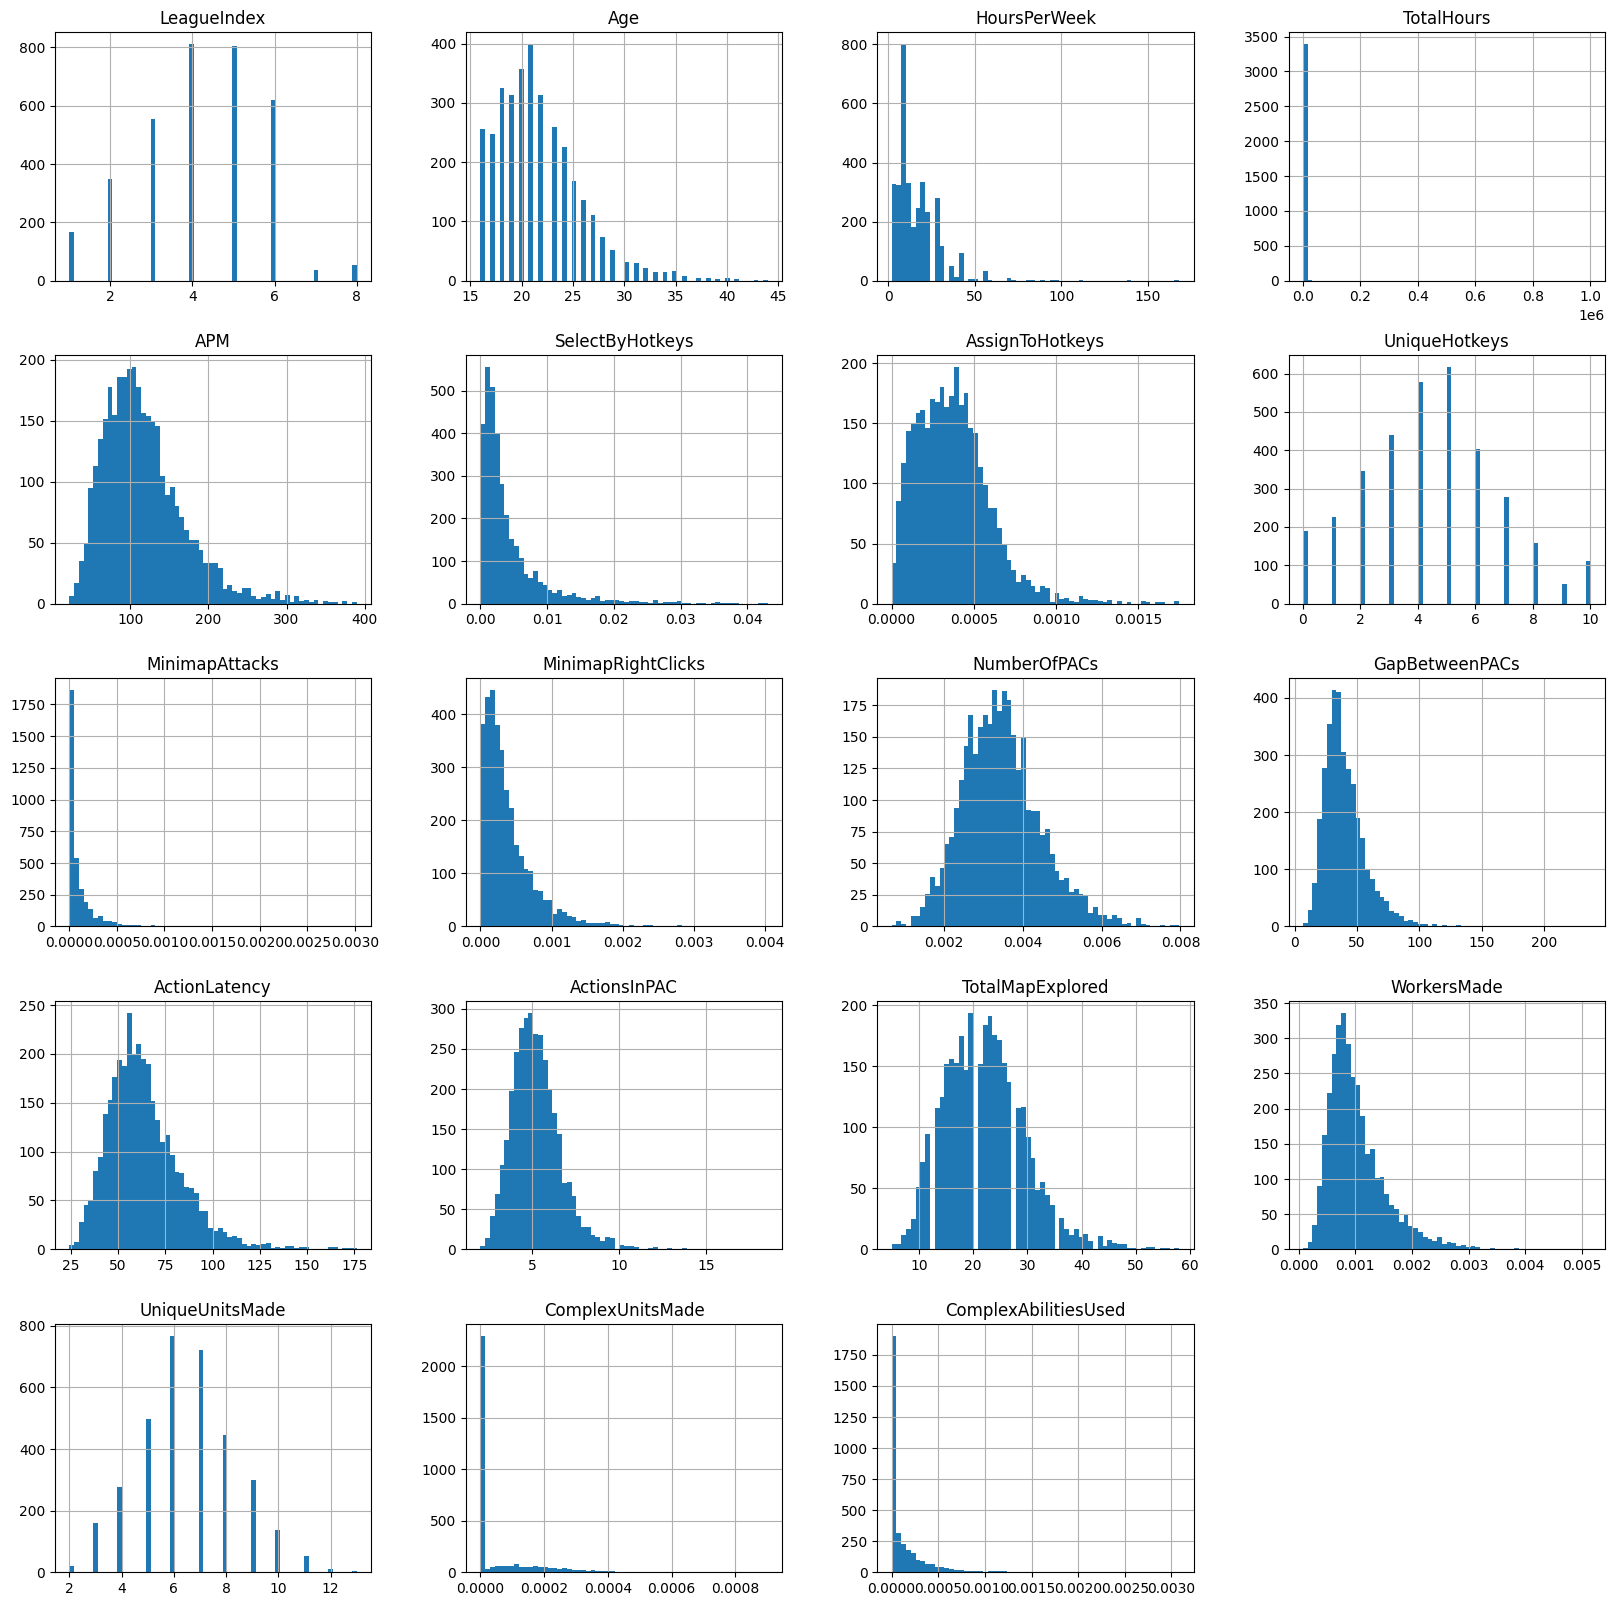

In [17]:
df_rep.hist(bins=60, figsize=(20, 20));

## Skewness

<font size='3'> To check the extent of the skewness, I used skew() function. Ideally for Normal Distributions the skewness level should be between -1 and 1.</font>

In [18]:
for column in df_rep.columns:
    print(column,' ', df_rep[column].skew())

LeagueIndex   -0.16335848835584843
Age   1.1686487040977005
HoursPerWeek   2.56248195046941
TotalHours   58.05062784127176
APM   1.2044502448138221
SelectByHotkeys   2.9653288739808947
AssignToHotkeys   1.1413170799516998
UniqueHotkeys   0.20827949675211357
MinimapAttacks   4.8191624735702385
MinimapRightClicks   2.5638199908682635
NumberOfPACs   0.5503794030392924
GapBetweenPACs   1.9082825762546316
ActionLatency   1.1516554826634637
ActionsInPAC   1.5990491180205209
TotalMapExplored   0.6299973302794324
WorkersMade   1.661404465029941
UniqueUnitsMade   0.18832426776415156
ComplexUnitsMade   2.3014040322600615
ComplexAbilitiesUsed   3.778854560804163


<font size='3'> It can be seen that columns like TotalHours, MinimapAttacks, etc have skewness > 1 meaning they are right-skewed. Ideally all columns that have skewness greater than 1 should be fixed to get a Normal distribution but as this means that a lot of the columns had to be modified, I chose to be liberal with the threshold for skewness and fixed it to 2.</font>

## Outliers Detection and Fixation

In [19]:
outlier_cols = []
for column in df_rep.columns:
    if (df_rep[column].skew()>2) or (df_rep[column].skew()<-2):
        outlier_cols.append(column)
        
print(outlier_cols)

['HoursPerWeek', 'TotalHours', 'SelectByHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']


<font size='3'> To visualize the distribution before fixing the outliers, I defined a function to generate box-plots.</font>

In [20]:
def plot_boxplot(num_plots):
    num_rows = (num_plots // 3) + (num_plots % 2 > 0)
    num_cols = min(num_plots, 2)

    fig, axes = plt.subplots(1, num_plots, figsize=(12, 6))

    for i, column in enumerate(outlier_cols[:num_plots]):
        sns.boxplot(data=df_rep, x=column, ax=axes[i])
        axes[i].set_title(column)

    plt.tight_layout()

    plt.show()

<font size='3'>Plotting boxplots before fixing outliers:</font>

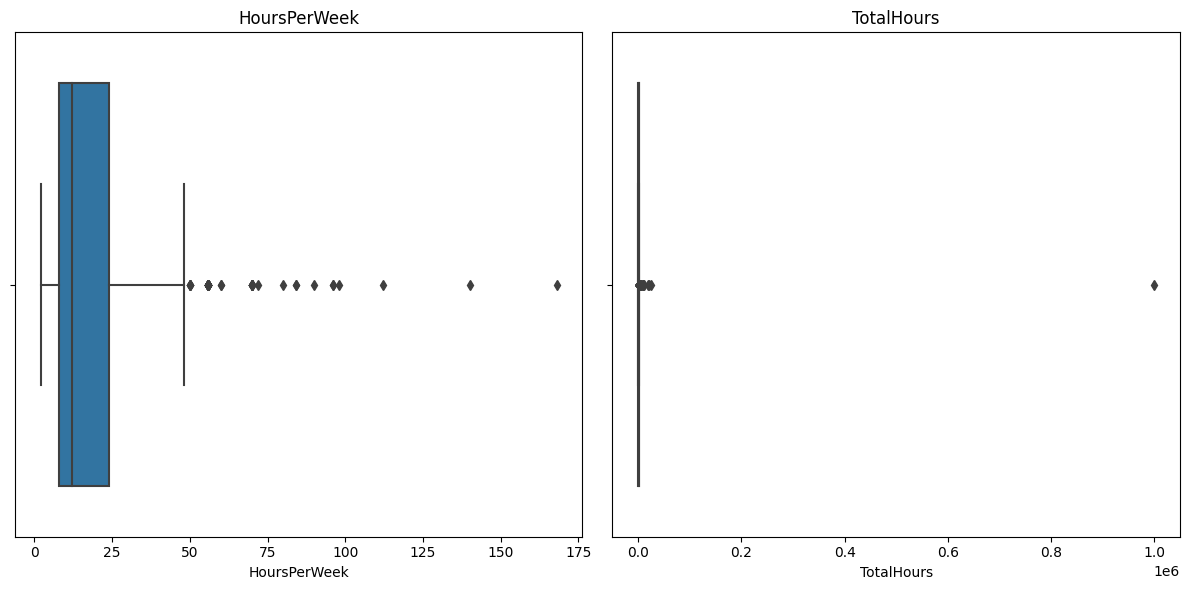

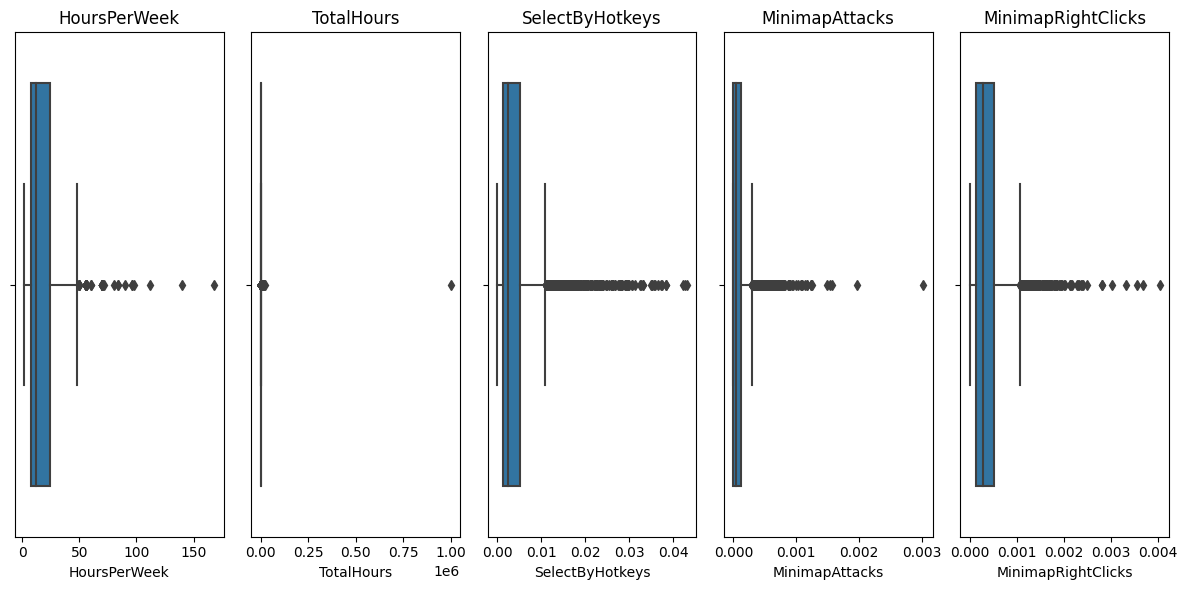

In [21]:
plot_boxplot(len(outlier_cols[:2]))
plot_boxplot(len(outlier_cols[2:]))

<font size='3'>To fix the outlier, we apply the concept of flooring and capping. Flooring and capping is a technique used to fix outliers by setting a lower and upper limit, respectively, to the extreme values in a dataset. It involves replacing values below the floor and above the cap with the floor and cap values, effectively limiting the range of the variable.</font>

In [22]:
def outlier_fixation(column):
    Q1 = df_rep[column].quantile(0.25)
    Q3 = df_rep[column].quantile(0.75)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 - (whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    df_rep[column]=np.where(df_rep[column]>upper_whisker,upper_whisker,np.where(df_rep[column]<lower_whisker,lower_whisker,df_rep[column]))


In [23]:
for col in outlier_cols:
    outlier_fixation(col)

<font size='3'>Plotting boxplots after fixing outliers:<br>
(The difference in the boxplots are evident)</font>

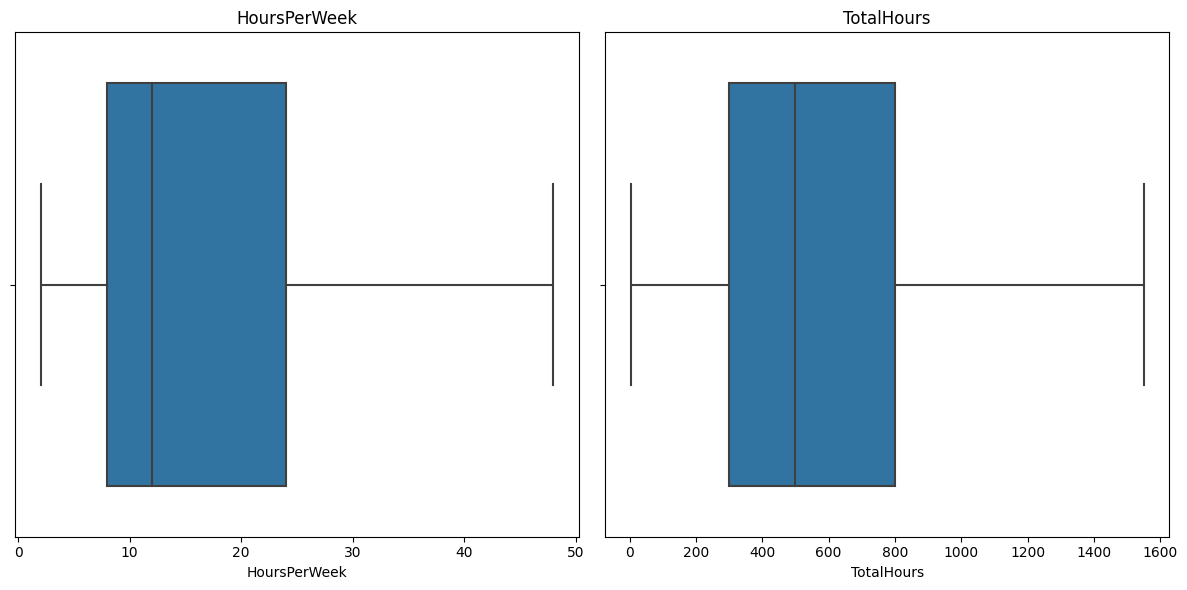

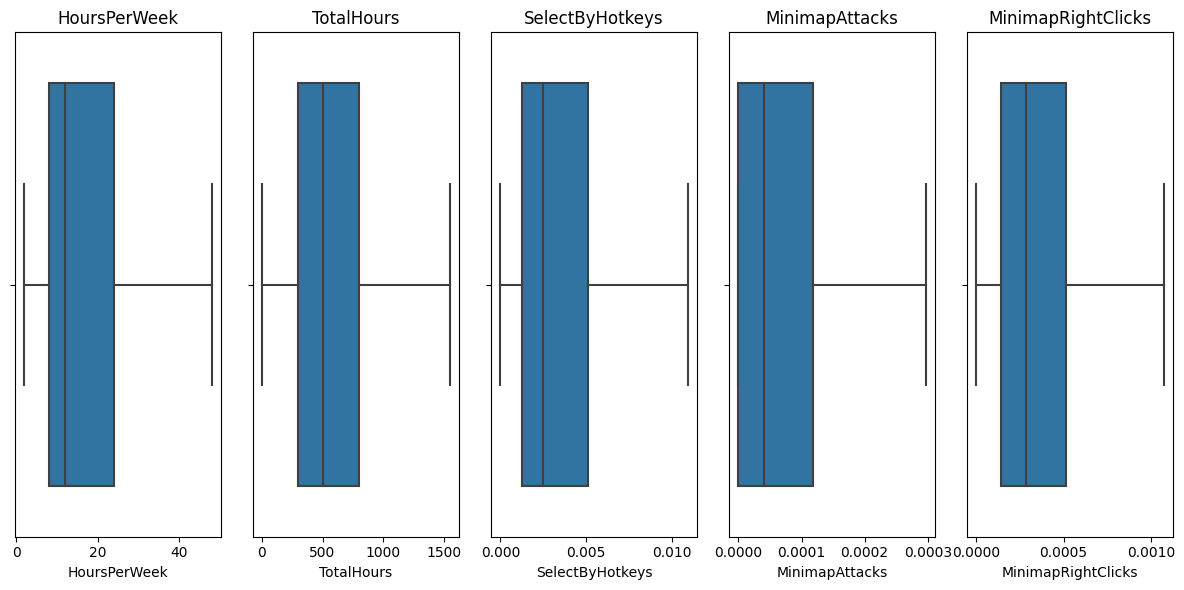

In [24]:
plot_boxplot(len(outlier_cols[:2]))
plot_boxplot(len(outlier_cols[2:]))

## Correlation Matrix of all features

<font size='3'> Before proceeding with modelling phase, I wanted to check how correlated each feature is with the target variable: 'LeagueIndex'.</font>

In [25]:
correlation_matrix = df_rep.corr()

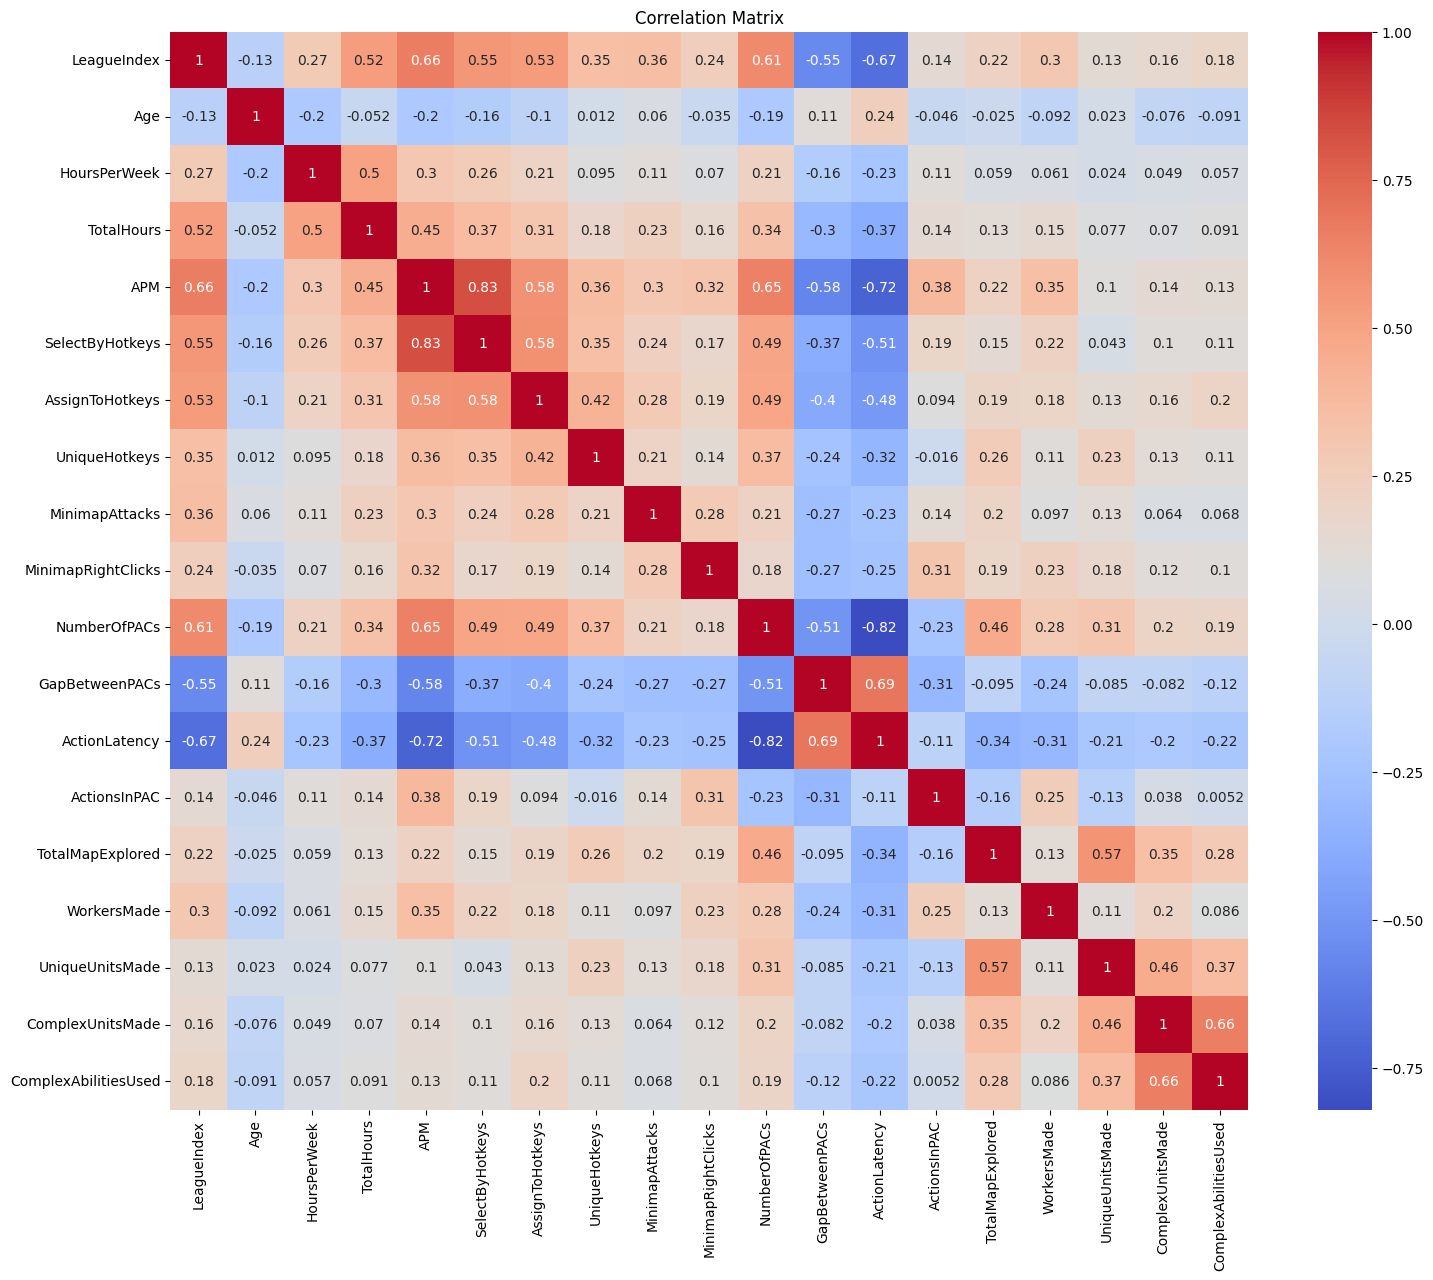

In [26]:
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

<font size='3'> There is clear correlation of certain columns and I thought it was better to only use those columns for the training which had a correlation value greater than the threshold. After observing the matrix, I decided the threshold to be 0.3 and found all the important columns.</font>

In [27]:
threshold = 0.3
target_column = 'LeagueIndex'
correlated_columns = correlation_matrix[correlation_matrix[target_column].abs() >= threshold].index.tolist()
noncorrelated_columns = correlation_matrix[correlation_matrix[target_column].abs() < threshold].index.tolist()

In [28]:
correlated_columns

['LeagueIndex',
 'TotalHours',
 'APM',
 'SelectByHotkeys',
 'AssignToHotkeys',
 'UniqueHotkeys',
 'MinimapAttacks',
 'NumberOfPACs',
 'GapBetweenPACs',
 'ActionLatency']

In [29]:
noncorrelated_columns

['Age',
 'HoursPerWeek',
 'MinimapRightClicks',
 'ActionsInPAC',
 'TotalMapExplored',
 'WorkersMade',
 'UniqueUnitsMade',
 'ComplexUnitsMade',
 'ComplexAbilitiesUsed']

## Data Modeling and Evaluation

In [30]:
dataset = df_rep

<font size='3'> Splitting the dataset into test and train sets after dropping the uncorrelated columns.</font>

In [31]:
X = dataset.drop(noncorrelated_columns, axis=1)
X = X.drop('LeagueIndex', axis=1)
names = X.columns
X = X.to_numpy()
Y = dataset['LeagueIndex'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True, test_size=0.2, stratify = Y)

<font size='3'>Scaling the data to reduce the variability in the values.</font>

In [32]:
scl = sk.preprocessing.StandardScaler()
X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)

<font size='3'> I defined a function to train different ML models and generate a classification report consisting of the various metrics like Accuracy, MSE, RMSE, R².</font>

In [33]:
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    MSE = np.mean((y_test - y_pred)**2)
    RMSE = np.sqrt(MSE)
    R_squared = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
    print("Classification Report for",classifier)
    print(classification_report(y_test, y_pred))
    print('MSE: ', MSE)
    print('RMSE: ', RMSE)
    print('R²: ', R_squared)
    print('===============================================================')
    print(' ')

In [34]:
lgr_clf = LogisticRegression(max_iter=10000)
rf_clf = RandomForestClassifier(n_estimators=1000)
ada_clf = AdaBoostClassifier()
xgb_clf = xgb.XGBClassifier()

train_and_evaluate_classifier(lgr_clf, X_train_scaled, y_train, X_test_scaled, y_test)
train_and_evaluate_classifier(rf_clf, X_train, y_train, X_test, y_test)
train_and_evaluate_classifier(ada_clf, X_train_scaled, y_train, X_test_scaled, y_test)
train_and_evaluate_classifier(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test)

Classification Report for LogisticRegression(max_iter=10000)
              precision    recall  f1-score   support

           1       0.54      0.42      0.47        33
           2       0.34      0.29      0.31        70
           3       0.34      0.23      0.27       111
           4       0.40      0.57      0.47       162
           5       0.42      0.40      0.41       161
           6       0.59      0.62      0.61       124
           7       0.00      0.00      0.00         7
           8       1.00      0.55      0.71        11

    accuracy                           0.44       679
   macro avg       0.45      0.38      0.41       679
weighted avg       0.44      0.44      0.43       679

MSE:  0.9646539027982327
RMSE:  0.982167960584254
R²:  0.5804925671596741
 
Classification Report for RandomForestClassifier(n_estimators=1000)
              precision    recall  f1-score   support

           1       0.50      0.36      0.42        33
           2       0.40      0.31  

<font size='3'> I observed that the accuracy was not significant and I believe this is because the dataset is highly imbalanced especially for the 'LeagueIndex' = 7 and 8. To make it balanced, I did oversampling using Synthetic Minority Oversampling Technique (SMOTE) which is a statistical technique for increasing the number of cases in the dataset in a balanced way.</font>

In [35]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

<font size='3'> This makes all the classes balanced and the number of instances in each class is equal to the maximum no. of instances in any class.</font>

In [36]:
unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

Class Distribution: {1: 811, 2: 811, 3: 811, 4: 811, 5: 811, 6: 811, 7: 811, 8: 811}


<font size='3'> The splitting of data is carried out again using the sampled data. <font size='3'>

In [37]:
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.2, stratify = y_resampled)
scl = sk.preprocessing.StandardScaler()
X_resampled_train_scaled = scl.fit_transform(X_resampled_train)
X_resampled_test_scaled = scl.transform(X_resampled_test)

## Hyperparameter Tuning

<font size='3'> I also wanted to do hyperparameter tuning and hence I proceeded with GridSearchCV but this did not have any major impact on the accuracy score of the AdaBoost model.</font>

In [38]:
ada_clf = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.5, 1.0]   
}

grid_search = GridSearchCV(ada_clf, param_grid, cv=5)
grid_search.fit(X_resampled_train_scaled, y_resampled_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 100}
Best Score: 0.37341040462427744


In [39]:
xgb_clf = XGBClassifier()

param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.5, 1.0]
}

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5)
grid_search.fit(X_resampled_train_scaled, y_resampled_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 1000}
Best Score: 0.6263969171483621


## Classification Report after Oversampling

In [40]:
lgr_clf = LogisticRegression(max_iter=10000)
rf_clf = RandomForestClassifier(n_estimators=1000)
ada_clf = AdaBoostClassifier(learning_rate=0.1, n_estimators=200)
xgb_clf = xgb.XGBClassifier(learning_rate=0.5, n_estimators=1000)

train_and_evaluate_classifier(lgr_clf, X_resampled_train_scaled, y_resampled_train, X_resampled_test_scaled, y_resampled_test)
train_and_evaluate_classifier(rf_clf, X_resampled_train, y_resampled_train, X_resampled_test, y_resampled_test)
train_and_evaluate_classifier(ada_clf, X_resampled_train_scaled, y_resampled_train, X_resampled_test_scaled, y_resampled_test)
train_and_evaluate_classifier(xgb_clf, X_resampled_train_scaled, y_resampled_train, X_resampled_test_scaled, y_resampled_test)


Classification Report for LogisticRegression(max_iter=10000)
              precision    recall  f1-score   support

           1       0.57      0.69      0.62       162
           2       0.32      0.28      0.30       162
           3       0.31      0.31      0.31       162
           4       0.30      0.29      0.30       163
           5       0.35      0.34      0.34       162
           6       0.39      0.37      0.38       162
           7       0.71      0.73      0.72       163
           8       0.86      0.90      0.88       162

    accuracy                           0.49      1298
   macro avg       0.48      0.49      0.48      1298
weighted avg       0.48      0.49      0.48      1298

MSE:  1.0431432973805854
RMSE:  1.0213438683325933
R²:  0.8011892500304014
 
Classification Report for RandomForestClassifier(n_estimators=1000)
              precision    recall  f1-score   support

           1       0.81      0.91      0.85       162
           2       0.71      0.73 

<font size='3'> Getting the classification report after sampling the data. This improved the accuracy of Random Forest Classifier from __44%__ to __69%__ and of XGBClassifier from __42%__ to __64%__ which is a major change in this case. This implies that there is a possibility of making better predictions if we can collect more and nearly equal amount of data for all the classes.</font>

## Hypothetical Question

<font size='3'> __Question:__ After seeing your work, your stakeholders come to you and say that they can collect more data, but want your guidance before starting. How would you advise them based on your EDA and model results? </font>

<font size='3'> __Answer:__

<font size='3'>Based on the insights I have gained from my analysis, it is clear that artificially generating data has significantly improved the accuracy of our model. However, we must consider that the artificially generated data may not always accurately represent real-life scenarios. Nevertheless, the importance of having a balanced dataset cannot be ignored, as it greatly enhances the performance of the models.

<font size='3'>Considering the current situation, it is advisable to gather more data for players whose LeagueIndex lacks sufficient representation. By doing so, we can ensure a more comprehensive and reliable dataset, leading to the development of robust models with improved predictive accuracy.

<font size='3'>Before collecting additional data, it would be beneficial to carefully consider the specific attributes and factors that contribute to a player's rank. I have identifed those key variables that influence the prediction which can help in the targeted collection of relevant data. Those variables are the 'correlated columns'.

<font size='3'>Additionally, it is essential to ensure the quality and consistency of the collected data. Clear guidelines and standards should be established to maintain data integrity and minimize biases. Furthermore, exploring different data collection methods, such as surveys or additional game metrics, could provide valuable insights into the players' performance and help augment the existing dataset.

<font size='3'>Regular monitoring and evaluation of the model's performance should be conducted as new data is added. This will enable us to assess the impact of the additional data and determine if any further adjustments or fine-tuning of the model are necessary.

<font size='3'>To conclude, based on the analysis, I would recommend collecting more data for players with insufficient representation, while being mindful of data quality and considering relevant variables. This approach, coupled with regular model evaluation, will likely lead to the development of more accurate and robust prediction models.
</font>

#### To explain the key findings to the non-technical stakeholders, I have prepared a PPT.

## Thank you!